In [18]:
#player index, team may matter in chosing who plays first and who doesn't
#for now I won't use them, but should be considered 
#also role may be important, for now only goalkeeper will be accounted for in the final dataframe
#if a team is away or home depends on the order of the report so team 0 will be home, team 1 away


#it seems some players are missing in the list of players (e.g. Antonino Barilla')

In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

In [20]:
%run SodaKick_download_functions.ipynb

In [21]:
#all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220203.h5',key='pl') #,format='table'

In [22]:
#there are players who changed team during a year, I'm keeping them separate, but could be averaged somehow

In [23]:
"""df_outfield=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Outfield.hdf',key='pl')
df_team=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Team.hdf',key='pl')
df_vs=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Vs.hdf',key='pl')
df_keeper=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_keeper.hdf',key='pl')
df_fix=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_fix.hdf',key='pl')"""

"df_outfield=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Outfield.hdf',key='pl')\ndf_team=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Team.hdf',key='pl')\ndf_vs=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_Vs.hdf',key='pl')\ndf_keeper=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_keeper.hdf',key='pl')\ndf_fix=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/SA2021_fix.hdf',key='pl')"

# Clean up

In [24]:
def clean_dataframe(df_outfield):

    df_outfield=df_outfield.fillna(0)

    df_outfield=df_outfield.drop(['age'],axis=1)
    df_outfield.columns=[x[:-3] if x.endswith('_gk') else x for x in df_outfield.columns]

    #df_outfield.nationality  = df_outfield.nationality.apply(lambda x: x.split()[1])
    #df_outfield.nationality = pd.Categorical(df_outfield.nationality)
    #df_outfield.position = pd.Categorical(df_outfield.position)
    #df_outfield.squad = pd.Categorical(df_outfield.squad)

    df_outfield.nationality = df_outfield.nationality.replace(0,'na N/A')
    df_outfield.nationality = df_outfield.nationality.apply(lambda x: x.split(' ')[1] if ' ' in x else x)
    
    df_outfield.position = df_outfield.position.replace(0,'N/A')

    # I'm splitting players who played in different teams through the year into separate players
    # consider averaging them
    df_outfield['player']= df_outfield['player'] +' ('+df_outfield['squad']+')'
    
        
    df_outfield.set_index('player', inplace=True, drop=True)
    df_outfield=df_outfield[[x for x in df_outfield.columns if '90' not in x]]
    df_outfield=df_outfield.loc[:, ~(df_outfield==0).all(axis=0)]
        
    df_outfield[df_outfield.columns.difference(['nationality','position','squad'])]=\
        df_outfield[df_outfield.columns.difference(['nationality','position','squad'])].astype(float)
    df_outfield['birth_year']=df_outfield['birth_year'].astype(int)

        
    #normalize game starts and minutes by the number of games played
    #df_outfield[['games_starts_per_game','minutes_per_game']]=df_outfield[['games_starts','minutes']].div(df_outfield['games'], axis=0)

    #normalize by minutes played
    #df_outfield[[x+'_per_minute' for x in df_outfield.columns.difference(['nationality','position','squad']+\
    #                                           ['birth_year', 'games', 'games_starts', 'minutes', 'games_starts_per_game', 'minutes_per_game']+\
    #                                           [x for x in df_outfield.columns if 'x' in x]+\
    #                                           [x for x in df_outfield.columns if '_pct' in x])]] = \
    #df_outfield[df_outfield.columns.difference(['nationality','position','squad']+\
    #                                               ['birth_year', 'games', 'games_starts', 'minutes', 'games_starts_per_game', 'minutes_per_game']+\
    #                                               [x for x in df_outfield.columns if 'x' in x]+\
    #                                               [x for x in df_outfield.columns if '_pct' in x])]\
    #                                               .div(df_outfield['minutes'],axis=0)
    
    storage=df_outfield[['nationality','position','squad']]
    
    #remove duplicate players 
    age=df_outfield['birth_year'][~df_outfield.index.duplicated(keep='first')]
    storage=storage[~df_outfield.index.duplicated(keep='first')]
    
    df_outfield=df_outfield.sum(level=0)

    df_outfield['birth_year']=age.astype(int)
    df_outfield[['nationality','position','squad']]=storage
        
    
    return df_outfield


In [25]:
def clean_all(name):
    df_outfield=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/'+name+'_Outfield.hdf',key='pl')
    df_keeper=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/'+name+'_keeper.hdf',key='pl')

    df_outfield=clean_dataframe(df_outfield)
    df_outfield['keeper']=0
    
    df_keeper=clean_dataframe(df_keeper)
    df_keeper.drop(['nationality','position','squad'],axis=1,inplace=True)
    df_keeper['keeper']=1
    
    df_players=pd.concat([df_outfield,df_keeper],axis=1, join='outer').fillna(0)
    df_players['league']=name[:2]
    df_players['season']=int(name[2:])
    
    df_players.reset_index(drop=False, inplace=True)
    df_players = df_players.loc[:,~df_players.columns.duplicated()]
    
    return df_players


In [26]:
all_players=[]

for league in ['SA','BL','LU','PL','LL']:
    for season in ['2122','2021','1920','1819','1718']:
        all_players.append(clean_all(league+season))
        
all_players = pd.concat(all_players,axis=0,ignore_index=True)


#average 
grp = all_players.groupby('player')

avg = pd.concat([grp.mean(),
grp['league'].agg(lambda x:x.value_counts().index[0]),
grp['nationality'].agg(lambda x:x.value_counts().index[0]),
grp['player'].agg(lambda x:x.value_counts().index[0]),
grp['position'].agg(lambda x:x.value_counts().index[0]),
grp['squad'].agg(lambda x:x.value_counts().index[0])],axis=1)
avg['season']='average'
avg.reset_index(drop=True,inplace=True)

all_players=pd.concat([all_players,avg],axis=0)
                   
#average and weighted average will be done on the fly

#multiindex can't save on h5 with fixed format='f' needs to be table 't' but it's slower will be done on the fly
#index = pd.MultiIndex.from_arrays(df_players[['player','season','league']].T.values, names=('player','season','league'))
#df_players.drop(['player','season','league'],axis=1,inplace=True)
#df_players.index=index

all_players.fillna(0)

all_players.reset_index(drop=True,inplace=True)
all_players.to_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5',key='pl') #,format='table'

KeyboardInterrupt: 

# fix missing birth years

In [13]:
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5')
#all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220203.h5',key='pl') #,format='table'

,player,birth_year,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,...,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_stopped,crosses_stopped_pct,def_actions_outside_pen_area,avg_distance_def_actions,league,season,gca_og_for
2875,Christian Rutjens (Benevento),0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SA,1718,NaN
10922,Javier Llabrés (Mallorca),0.0,2.0,1.0,93.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LL,2122,NaN
14524,Christian Rutjens (Benevento),0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SA,average,NaN
16232,Javier Llabrés (Mallorca),0.0,2.0,1.0,93.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LL,average,NaN


In [14]:
for i in all_players[all_players['player'].str.contains('Javier Llabrés')].index:
    all_players.loc[i,'birth_year']=2002
    
for i in all_players[all_players['player'].str.contains('Christian Rutjens')].index:
    all_players.loc[i,'birth_year']=1998

In [16]:
all_players.to_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5',key='pl')

//miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2621: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['player', 'nationality', 'position', 'squad', 'league', 'season'], dtype='object')]

  encoding=encoding,


# weighted average per team

In [308]:
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5')

categorical = ['player','league','squad','season','position','nationality','birth_year']
to_avg = [x for x in all_players.columns if 'avg' in x or 'pct' in x or 'xg' in x or 'xa' in x or '_per_' in x]
to_sum = [x for x in all_players.columns if x not in categorical and x not in to_avg]

In [309]:
weighted_players = all_players.copy(deep=True)
weighted_players = weighted_players[weighted_players['season']!='average']
weighted_players['player']=weighted_players['player'].apply(lambda x: x.split('(')[0].rstrip())

transformed=[]

for season in weighted_players.season.unique():
    tmp = weighted_players[weighted_players['season']==season]

    grouped = tmp.groupby('player')

    """ Averaging """
    denominator = grouped['minutes'].sum()
    tmp.set_index('player',drop=True,inplace=True)
    numerator = tmp[to_avg].mul(tmp['minutes'],axis=0)
    averaged=numerator.groupby('player').sum().div(grouped['minutes'].sum(),axis=0)
        
    """ Summing """
    summed=grouped[to_sum].sum()
    
    """ Same """
    same=grouped[['season','birth_year','nationality']].first()
    
    """ Multiple """
    multiple=grouped[['squad','league','position']].transform(lambda x: ','.join(x)).applymap(lambda x: ','.join(set(x.split(','))))
    multiple=multiple[~multiple.index.duplicated(keep='first')]
    
    transformed.append(pd.concat([same,multiple,summed,averaged],axis=1))
    
weighted_players=pd.concat(transformed,axis=0)
weighted_players.reset_index(drop=False,inplace=True)

In [310]:
grouped = weighted_players.groupby('player')

""" Averaging """
averaged=grouped[[x for x in weighted_players if x not in categorical]].mean()

""" Same """
same=grouped[['birth_year','nationality']].first()

""" Multiple """
multiple=grouped[['player','squad','league','position']].transform(lambda x: ','.join(x)).applymap(lambda x: ','.join(set(x.split(','))))
multiple.set_index('player',drop=True,inplace=True)
multiple=multiple[~multiple.index.duplicated(keep='first')]

transformed=pd.concat([same,multiple,averaged],axis=1)
transformed.reset_index(drop=False,inplace=True)
transformed['season']='average'



In [311]:
weighted_players=pd.concat([weighted_players,transformed],axis=0)
weighted_players.reset_index(drop=True,inplace=True)

In [312]:
weighted_players.to_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')

//miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2621: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['player', 'season', 'nationality', 'squad', 'league', 'position'], dtype='object')]

  encoding=encoding,


# averaging per years

In [17]:
weighted_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')
weighted_players=weighted_players[weighted_players['season']!='average']

categorical = ['player','league','squad','season','position','nationality','birth_year']
to_avg = [x for x in weighted_players.columns if 'avg' in x or 'pct' in x or 'xg' in x or 'xa' in x or '_per_' in x]
to_sum = [x for x in weighted_players.columns if x not in categorical and x not in to_avg]

In [18]:
allsea=['2021','1920','1819','1718']
alltrans=[]

for i,sea in enumerate(['2122','2021','1920','1819']):
    print(sea,allsea[i:])
    
    tmp=weighted_players[weighted_players['season'].astype(str).isin(allsea[i:])]
    grouped = tmp.groupby('player')

    """ Averaging """
    averaged=grouped[[x for x in tmp if x not in categorical]].mean()

    """ Same """
    same=grouped[['birth_year','nationality']].first()

    """ Multiple """
    multiple=grouped[['player','squad','league','position']].transform(lambda x: ','.join(x)).applymap(lambda x: ','.join(set(x.split(','))))
    multiple.set_index('player',drop=True,inplace=True)
    multiple=multiple[~multiple.index.duplicated(keep='first')]

    transformed=pd.concat([same,multiple,averaged],axis=1)
    transformed.reset_index(drop=False,inplace=True)
    transformed['season']='avg'+sea
    
    alltrans.append(transformed)
    
alltrans=pd.concat(alltrans,axis=0) 
alltrans.reset_index(drop=True,inplace=True)
alltrans.to_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_avgs_220303.h5',key='pl')

2122 ['2021', '1920', '1819', '1718']
2021 ['1920', '1819', '1718']
1920 ['1819', '1718']
1819 ['1718']


# weighted averaging per year

In [19]:
weighted_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')
weighted_players=weighted_players[weighted_players['season']!='average']

categorical = ['player','league','squad','season','position','nationality','birth_year']
to_avg = [x for x in weighted_players.columns if 'avg' in x or 'pct' in x or 'xg' in x or 'xa' in x or '_per_' in x]
to_sum = [x for x in weighted_players.columns if x not in categorical and x not in to_avg]

In [20]:
allsea=['2021','1920','1819','1718']
weights=[1,.5,.25,.125]
alltrans=[]

weighted_players['weights']=0
for sea,wei in zip(allsea,weights):
    weighted_players.at[weighted_players['season'].astype(str)==sea,'weights']=wei

weighted_players[[x for x in tmp if x not in categorical]]=weighted_players[[x for x in tmp if x not in categorical]].mul(weighted_players['weights'],axis=0)
    

for i,sea in enumerate(['2122','2021','1920','1819']):
    print(sea,allsea[i:])
    
    tmp=weighted_players[weighted_players['season'].astype(str).isin(allsea[i:])]
    tmp[[x for x in tmp if x not in categorical]]=tmp[[x for x in tmp if x not in categorical]].div(sum(weights[1:]))
    
    grouped = tmp.groupby('player')

    """ Averaging """
    averaged=grouped[[x for x in tmp if x not in categorical]].sum()

    """ Same """
    same=grouped[['birth_year','nationality']].first()

    """ Multiple """
    multiple=grouped[['player','squad','league','position']].transform(lambda x: ','.join(x)).applymap(lambda x: ','.join(set(x.split(','))))
    multiple.set_index('player',drop=True,inplace=True)
    multiple=multiple[~multiple.index.duplicated(keep='first')]

    transformed=pd.concat([same,multiple,averaged],axis=1)
    transformed.reset_index(drop=False,inplace=True)
    transformed['season']='wavg'+sea
    
    alltrans.append(transformed)
    
alltrans=pd.concat(alltrans,axis=0) 
alltrans.reset_index(drop=True,inplace=True)
alltrans.drop('weights',axis=1,inplace=True)
alltrans.to_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_wavgs_220303.h5',key='pl')

2122 ['2021', '1920', '1819', '1718']


//miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


2021 ['1920', '1819', '1718']
1920 ['1819', '1718']
1819 ['1718']


# fixtures

In [324]:
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')

with open(r'/Users/federico comitani/GitHub/sodakick/data/tsvd_220223.pkl', 'rb') as pk:
    ts=pickle.load(pk)
    
tmp=all_players.copy(deep=True)
tmp.drop(['player','squad','position','season','nationality','league'],axis=1,inplace=True)
tmpmean=tmp.mean(axis=0)
tmpstd=tmp.std(axis=0)
#tmp=(tmp-tmpmean)/tmpstd
#tmp.fillna(0,inplace=True)

avg_players=all_players[all_players['season']=='average']
avg_players.set_index('player',drop=True,inplace=True)
avg_players.drop(['squad','position','season','nationality','league'],axis=1,inplace=True)
avg_players_svd=(avg_players-tmpmean)/tmpstd
avg_players_svd.fillna(0,inplace=True)

avg_players_svd=pd.DataFrame(ts.transform(avg_players_svd), index=avg_players.index)

df_fixs=[]
for series in ['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']+\
              ['SA1819','SA1718','BL1819','BL1718','LU1819','LU1718','PL1819','PL1718','LL1819','LL1718']:
    
    df_fixs.append(pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/'+series+'_Fix.hdf'))

//miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
def build_team_from_lineup(lineup, df_players):

    df_players=df_players.loc[lineup.index.intersection(df_players.index)]

    df_players=df_players.append(pd.DataFrame(np.nan, columns=df_players.columns, index=lineup.index.difference(df_players.index)))
    df_players=df_players.loc[lineup.index].fillna(0)
    
    df_players['bench']=lineup['bench']
    df_players['team']=lineup['team']
    #missing=df_players[df_players.isna().any(axis=1)].index

    #df_players = df_players[~df_players.index.duplicated(keep='first')]
    #df_players = df_players.fillna(0)
    
    return df_players, lineup.index.difference(df_players.index)

def fillto50(lineup):
    
    team1=lineup[lineup['team']==0]
    if len(team1)<24:
        team1=team1.append(pd.DataFrame([[0,1,lineup['formation'].unique()[0]]]*(24-team1.shape[0]), 
                                        columns=team1.columns, 
                                        index=['dummy1'+str(x) for x in range((24-team1.shape[0]))]))

    team2=lineup[lineup['team']==1]
    if len(team2)<24:
        team2=team2.append(pd.DataFrame([[1,1,lineup['formation'].unique()[1]]]*(24-team2.shape[0]), 
                                        columns=team2.columns, 
                                        index=['dummy2'+str(x) for x in range((24-team2.shape[0]))]))

    return pd.concat([team1,team2],axis=0)

def clean_report(match, df_players):
    
        team1,team2,gk1,gk2,shots,lineup=get_report_data(path=match)
        teams=pd.concat([team1,team2],axis=0).reset_index(drop=True)
        gks=pd.concat([gk1,gk2],axis=0).reset_index(drop=True)

        teams.set_index('player',drop=True,inplace=True)
        gks.set_index('player',drop=True,inplace=True)
        lineup.set_index('player',drop=True,inplace=True)

        #""" Added after separation of players by team."""
        #teams.index=[ix+' ('+lineup['team'].loc[ix]+')' for ix in teams.index]
        #gks.index=[ix+' ('+lineup['team'].loc[ix]+')' for ix in gks.index]
        #lineup.index=[ix+' ('+lineup['team'].loc[ix]+')' for ix in lineup.index]
        
        lineup['bench']=lineup['bench'].astype(int)
        lineup.team=(lineup.team==lineup.team.unique()[1]).astype(int)
        lineup=fillto50(lineup)
                     
        teams=teams[['minutes','goals','assists','cards_yellow','cards_red','own_goals']]
        gks.columns=[x[:-3] if x.endswith('_gk') else x for x in gks.columns]
        gks=gks[['goals_against','saves']]
        #results=pd.concat([teams,gks],axis=1).loc[lineup.index].fillna(0)
        
        results=pd.concat([teams,gks],axis=1)
        results=results.append(pd.DataFrame(np.nan, columns=results.columns, index=lineup.index.difference(results.index)))
        results=results.loc[lineup.index].fillna(0)
    
        
        inp, missing = build_team_from_lineup(lineup, df_players)

        #possibly redundant
        results.loc[missing]=0
        
        return inp, results, lineup

In [ ]:
inp, results, lineup = clean_report(df_fixs[0]['match_report'], avg_players_svd)

plt.scatter(inp[0],inp[1])
plt.scatter(inp[0].loc['dummy10'],inp[1].loc['dummy10'])
plt.scatter(inp[0].iloc[0],inp[1].iloc[0])

#dummy shouldn't be all zeroes, otherwise add one column that says it's a dummy
#same with the GK, hopefully doesn't need to be told it's a GK, bit maybe it helps
#same with formation, roles etc...

# build input/output for classifier training

In [357]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
outputs=[]
lineups=[]

exit=False

for i,series in enumerate(['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']):    
    print(series)
    
    for match in df_fixs[i]['match_report'].values:

        try:

            #for now just use the average of all players, then I can change it so that it's the average over the years
            
            inp, results, lineup = clean_report(match, avg_players_svd)
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break
                
            #randomize order of players

            inputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
            for seed in range(24):
                
                inputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                outputs.append(pd.concat([results[:24].sample(frac=1,random_state=seed),results[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                lineups.append(pd.concat([lineup[:24].sample(frac=1,random_state=seed),lineup[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())       

        except:

            pass
        
    if exit:
        break
        
    print(len(inputs))
    
inputs=np.array(inputs)
outputs=np.array(outputs)

with open(r'/Users/federico comitani/GitHub/sodakick/data/inp_a_220223.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_a_220223.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/lineup_a_220223.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA2122
5500
SA2021
13450
SA1920
21750
BL2122
26725
BL2021
34050
BL1920
38525
LU2122
44175
LU2021
52300
LU1920
58125
PL2122
63800
PL2021
72675
PL1920
81500
LL2122
85050
LL2021
93025
LL1920
101125


In [363]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
outputs=[]
lineups=[]

exit=False
for i,series in enumerate(['SA1819','SA1718','BL1819','BL1718','LU1819','LU1718','PL1819','PL1718','LL1819','LL1718']):
    
    print(series)
    
    for match in df_fixs[i+15]['match_report'].values:

        try:

            inp, results, lineup = clean_report(match, avg_players_svd)
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break

            #randomize order of players

            inputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
            for seed in range(24):
                
                inputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                outputs.append(pd.concat([results[:24].sample(frac=1,random_state=seed),results[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                lineups.append(pd.concat([lineup[:24].sample(frac=1,random_state=seed),lineup[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())   
            
        except:

            pass

    print(len(inputs))
    
inputs=np.array(inputs)
outputs=np.array(outputs)


with open(r'/Users/federico comitani/GitHub/sodakick/data/inp_b_220223.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_b_220223.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/lineup_b_220223.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA1819
8375
SA1718
16650
BL1819
23875
BL1718
31075
LU1819
38975
LU1718
46975
PL1819
55625
PL1718
63875
LL1819
72475
LL1718
81100


# trying and merging them

In [364]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/inp_a_220223.pkl', 'rb') as pk:
    inputs=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_a_220223.pkl', 'rb') as pk:
    outputs=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/inp_b_220223.pkl', 'rb') as pk:
    inputs2=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_b_220223.pkl', 'rb') as pk:
    outputs2=pickle.load(pk)

In [365]:
inputs=np.concatenate([inputs,inputs2])
outputs=np.concatenate([outputs,outputs2])

In [366]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/inp_220223.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_220223.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)

# per year average and weighted average

In [37]:
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')
avg=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_avgs_220303.h5',key='pl')
wavg=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_wavgs_220303.h5',key='pl')

all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl')

with open(r'/Users/federico comitani/GitHub/sodakick/data/tsvd_220223.pkl', 'rb') as pk:
    ts=pickle.load(pk)
    
tmp=all_players.copy(deep=True)
tmp.drop(['player','squad','position','season','nationality','league'],axis=1,inplace=True)
tmpmean=tmp.mean(axis=0)
tmpstd=tmp.std(axis=0)
#tmp=(tmp-tmpmean)/tmpstd
#tmp.fillna(0,inplace=True)

avg_all={}
wavg_all={}

for i in ['2122','2021','1920','1819']:
    
    avg_players=avg[avg['season'].astype(str)=='avg'+i]
    avg_players.set_index('player',drop=True,inplace=True)
    avg_players.drop(['squad','position','season','nationality','league'],axis=1,inplace=True)
    avg_players_svd=(avg_players-tmpmean)/tmpstd
    avg_players_svd.fillna(0,inplace=True)

    avg_all[i]=pd.DataFrame(ts.transform(avg_players_svd), index=avg_players.index)
    
    
    avg_players=wavg[wavg['season'].astype(str)=='wavg'+i]
    avg_players.set_index('player',drop=True,inplace=True)
    avg_players.drop(['squad','position','season','nationality','league'],axis=1,inplace=True)
    avg_players_svd=(avg_players-tmpmean)/tmpstd
    avg_players_svd.fillna(0,inplace=True)

    wavg_all[i]=pd.DataFrame(ts.transform(avg_players_svd), index=avg_players.index)

df_fixs=[]
for series in ['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']+\
              ['SA1819','BL1819','LU1819','PL1819','LL1819']:
    
    df_fixs.append(pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/'+series+'_Fix.hdf'))

//miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
//miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
//miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
//miniconda3/lib/python3.7/site-packages/pandas/core

In [35]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
winputs=[]
outputs=[]
lineups=[]

exit=False

for i,series in enumerate(['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']):    
    print(series)
    
    for match in df_fixs[i]['match_report'].values:
        
        try:

            #for now just use the average of all players, then I can change it so that it's the average over the years
            
            inp, results, lineup = clean_report(match, avg_all[series[2:]])
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break
                
                
            winp, results, lineup = clean_report(match, wavg_all[series[2:]])
            
            if winp.shape[0]<48:
                print(match)
                exit=True
                break
                
            #randomize order of players

            inputs.append(inp.astype(float).values.flatten())
            winputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
            for seed in range(24):
                
                inputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                winputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                outputs.append(pd.concat([results[:24].sample(frac=1,random_state=seed),results[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                lineups.append(pd.concat([lineup[:24].sample(frac=1,random_state=seed),lineup[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())       

        except:

            pass
        
    if exit:
        break
        
    print(len(inputs))
    print(len(winputs))
    
inputs=np.array(inputs)
inputs=np.array(winputs)
outputs=np.array(outputs)

with open(r'/Users/federico comitani/GitHub/sodakick/data/ainp_a_220303.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_a_220303.pkl', 'wb') as pk:
    pickle.dump(winputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_a_220303.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/lineup_a_220303.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA2122
5500
5500
SA2021
13450
13450
SA1920
21750
21750
BL2122
26725
26725
BL2021
34050
34050
BL1920
41300
41300
LU2122
46950
46950
LU2021
55075
55075
LU1920
60900
60900
PL2122
66575
66575
PL2021
75450
75450
PL1920
84275
84275
LL2122
89900
89900
LL2021
97875
97875
LL1920
105975
105975


In [36]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
winputs=[]
outputs=[]
lineups=[]

exit=False

for i,series in enumerate(['SA1819','BL1819','LU1819','PL1819','LL1819']):
    print(series)
    
    for match in df_fixs[i]['match_report'].values:

        try:

            #for now just use the average of all players, then I can change it so that it's the average over the years
            
            inp, results, lineup = clean_report(match, avg_all[series[2:]])
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break
                
                
            winp, results, lineup = clean_report(match, wavg_all[series[2:]])
            
            if winp.shape[0]<48:
                print(match)
                exit=True
                break
                
            #randomize order of players

            inputs.append(inp.astype(float).values.flatten())
            winputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
            for seed in range(24):
                
                inputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                winputs.append(pd.concat([inp[:24].sample(frac=1,random_state=seed),inp[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                outputs.append(pd.concat([results[:24].sample(frac=1,random_state=seed),results[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())
                lineups.append(pd.concat([lineup[:24].sample(frac=1,random_state=seed),lineup[24:].sample(frac=1,random_state=seed)],axis=0).values.flatten())       

        except:

            pass
        
    if exit:
        break
        
    print(len(inputs))
    print(len(winputs))
    
inputs=np.array(inputs)
inputs=np.array(winputs)
outputs=np.array(outputs)

with open(r'/Users/federico comitani/GitHub/sodakick/data/ainp_b_220303.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_b_220303.pkl', 'wb') as pk:
    pickle.dump(winputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/out_b_220303.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/lineup_b_220303.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA1819
5500
5500
BL1819
13450
13450
LU1819
21750
21750
PL1819
26725
26725
LL1819
34050
34050


In [38]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/ainp_a_220303.pkl', 'rb') as pk:
    inputs=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_a_220303.pkl', 'rb') as pk:
    winputs=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_a_220303.pkl', 'rb') as pk:
    outputs=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/ainp_b_220303.pkl', 'rb') as pk:
    inputs2=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_b_220303.pkl', 'rb') as pk:
    winputs2=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_b_220303.pkl', 'rb') as pk:
    outputs2=pickle.load(pk)
    
    
inputs=np.concatenate([inputs,inputs2])
winputs=np.concatenate([winputs,winputs2])
outputs=np.concatenate([outputs,outputs2])


with open(r'/Users/federico comitani/GitHub/sodakick/data/ainp_220303.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_220303.pkl', 'wb') as pk:
    pickle.dump(winputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_220303.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)

# matches as one big df

In [52]:
import pandas as pd

df_fixs=[]
for series in ['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']+\
              ['SA1819','BL1819','LU1819','PL1819','LL1819']:
    
    df_fixs.append(pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/'+series+'_Fix.hdf'))

In [68]:
def clean_report_short(match):
    
        team1,team2,gk1,gk2,shots,lineup=get_report_data(path=match)
        teams=pd.concat([team1,team2],axis=0).reset_index(drop=True)
        gks=pd.concat([gk1,gk2],axis=0).reset_index(drop=True)

        teams.set_index('player',drop=True,inplace=True)
        gks.set_index('player',drop=True,inplace=True)
        lineup.set_index('player',drop=True,inplace=True)

        lineup['bench']=lineup['bench'].astype(int)
        lineup.team=(lineup.team==lineup.team.unique()[1]).astype(int)
                     
        teams=teams[['minutes','goals','assists','cards_yellow','cards_red','own_goals']]
        gks.columns=[x[:-3] if x.endswith('_gk') else x for x in gks.columns]
        gks=gks[['goals_against','saves']]
        #results=pd.concat([teams,gks],axis=1).loc[lineup.index].fillna(0)
        
        results=pd.concat([teams,gks],axis=1)
        results=results.append(pd.DataFrame(np.nan, columns=results.columns, index=lineup.index.difference(results.index)))
        results=results.loc[lineup.index].fillna(0)

        matchdetails=pd.concat([results,lineup],axis=1)
        matchdetails['match_index']=i
        matchdetails['formation']=matchdetails['formation'].str.strip('()')
        
        return matchdetails

In [70]:
#TAKES TOO MUCH TIME!
seriess=['SA2122','SA2021','SA1920','BL2122','BL2021','BL1920','LU2122','LU2021','LU1920','PL2122','PL2021','PL1920','LL2122','LL2021','LL1920']+\
              ['SA1819','BL1819','LU1819','PL1819','LL1819']

for j,df_fix in enumerate(df_fixs):
    
    print(seriess[j])
    
    df_fix['formation_a']=''
    df_fix['formation_b']=''
    
    all_matches=[]
    
    for i in range(df_fix.shape[0]):
    
        matchddetails = clean_report_short(df_fix['match_report'].iloc[i])
        
        df_fix.at[df_fix.index[i],'formation_a']=matchddetails['formation'].iloc[0]
        df_fix.at[df_fix.index[i],'formation_b']=matchddetails['formation'].iloc[-1]
        
        matchddetails.drop('formation',axis=1,inplace=True)

        all_matches.append(matchdetails)
        
    all_matches=pd.concat(all_matches,axis=0)
    all_matches.to_hdf('/Users/federico comitani/GitHub/sodakick/data/'+seriess[j]+'_match_reports.hdf', key='df')
    df_fixs.drop(['xg_a', 'xg_b', 'match_report'],axis=1)
    df_fix.to_hdf('/Users/federico comitani/GitHub/sodakick/data/'+seriess[j]+'_fix_up.hdf', key='df')


SA2122


KeyboardInterrupt: 

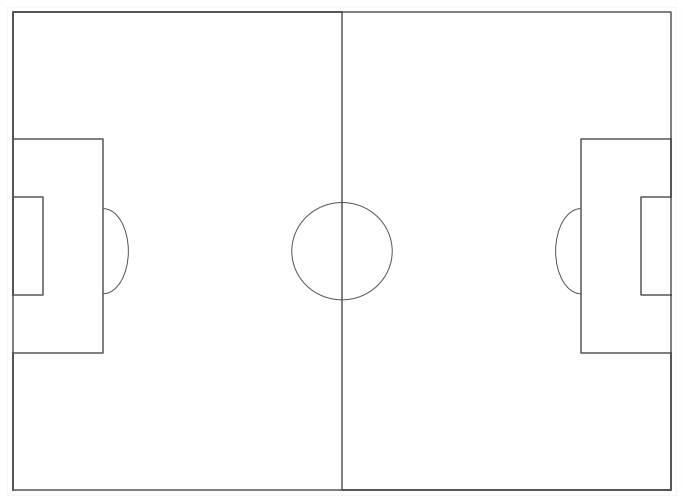

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_soccer_pitch(figsize=(12, 9)):
    """
    Function that plots a scaled soccer pitch of length 120*90 metres which 
    are the maximum dimensions allowed by FIFAs "Laws Of The Game"
    """
    rect = patches.Rectangle((-1, -1), 122, 92, linewidth=0.1,
                             edgecolor='r', facecolor='white', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)
    # Main pitch markings, ie sidelines, penalty area and halfway line
    plt.plot([0, 0,  0, 120, 120, 0,     0,  16.5,  16.5,     0,     0,   5.5,   5.5, 
                  0,  0, 60, 60, 120,   120, 103.5, 103.5,   120,   120, 114.5, 114.5,   120], 
             [0, 0, 90,  90,   0, 0, 25.85, 25.85, 66.15, 66.15, 55.15, 55.15, 36.85, 
              36.85, 90, 90,  0,   0, 25.85, 25.85, 66.15, 66.15, 55.15, 55.15, 36.85, 36.85], color='#555555')
    
    # Secondary pitch markings, ie penalty spots, centre circle etc
    #plt.plot([11, 11.5],[45, 45], color='#555555')
    #plt.plot([109, 108.5],[45, 45], color='#555555')
    
    centre_circle = patches.Circle([60, 45], 9.15, edgecolor='#555555', facecolor='white')
    ax.add_patch(centre_circle)
    
    left_arc = patches.Arc([16.5, 45], 9.15, 16, theta1=270.0, theta2=90.0, color='#555555')
    ax.add_patch(left_arc)
    right_arc = patches.Arc([103.5, 45], 9.15, 16, theta1=90.0, theta2=270.0, color='#555555')
    ax.add_patch(right_arc)
    
    #bl_corner = patches.Arc([0, 0], 2.5, 2.5, theta1=0.0, theta2=90.0, color='white')
    #tl_corner = patches.Arc([0, 90], 2.5, 2.5, theta1=270.0, color='white')
    #br_corner = patches.Arc([120, 0], 2.5, 2.5, theta1=90.0, theta2=180.0, color='white')
    #tr_corner = patches.Arc([120, 90], 2.5, 2.5, theta1=180.0, theta2=270.0,color='white')
    #ax.add_patch(bl_corner)
    #ax.add_patch(tl_corner)
    #ax.add_patch(br_corner)
    #ax.add_patch(tr_corner)
    
    plt.xlim(-1, 121)
    plt.ylim(-1, 91)
    plt.axis('off')    

    return fig, ax

draw_soccer_pitch()
plt.show()